## Question 2 - Target variable selection

In [1]:
import pandas as pd
import numpy as np
import os, sys
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

In [2]:
# GLOBALS
LOCAL_ROOT = '/Users/varunn/Documents/ExternalTest/'
PROJ_DIR = os.path.join(LOCAL_ROOT, 'Revolut')
DATA_DIR = os.path.join(PROJ_DIR, 'data')
DEVICES_FN = os.path.join(DATA_DIR, 'rev-devices.csv')
USERS_FN = os.path.join(DATA_DIR, 'rev-users.csv')
NOTIFICATIONS_FN = os.path.join(DATA_DIR, 'rev-notifications.csv')
TRANSACTIONS_FN = os.path.join(DATA_DIR, 'rev-transactions.csv')
OUT_DIR = os.path.join(PROJ_DIR, 'my_solution')

In [3]:
# read data
devices_df = pd.read_csv(DEVICES_FN)
users_df = pd.read_csv(USERS_FN)
notifications_df = pd.read_csv(NOTIFICATIONS_FN)
transactions_df = pd.read_csv(TRANSACTIONS_FN)

In [4]:
print(users_df.shape)
print(users_df.head())

(19430, 12)
  user_id  birth_year country       city                created_date  \
0  user_0        1989      PL     Gdansk  2018-01-13 05:15:15.599466   
1  user_1        1975      GB     London  2018-01-29 03:38:46.676876   
2  user_2        1987      PL     Poznań  2018-01-18 19:17:31.229096   
3  user_3        1994      FR      Paris  2018-01-15 18:47:56.723104   
4  user_4        1985      GB  Beckenham  2018-01-11 00:36:46.673673   

   user_settings_crypto_unlocked      plan  \
0                              1  STANDARD   
1                              0  STANDARD   
2                              0  STANDARD   
3                              0  STANDARD   
4                              0  STANDARD   

   attributes_notifications_marketing_push  \
0                                      1.0   
1                                      NaN   
2                                      0.0   
3                                      1.0   
4                                      NaN   

 

In [5]:
# converting created_date to datetime format
users_df['created_date'] = users_df['created_date'].apply(
    lambda x: pd.to_datetime(x))
print(users_df.head())

  user_id  birth_year country       city               created_date  \
0  user_0        1989      PL     Gdansk 2018-01-13 05:15:15.599466   
1  user_1        1975      GB     London 2018-01-29 03:38:46.676876   
2  user_2        1987      PL     Poznań 2018-01-18 19:17:31.229096   
3  user_3        1994      FR      Paris 2018-01-15 18:47:56.723104   
4  user_4        1985      GB  Beckenham 2018-01-11 00:36:46.673673   

   user_settings_crypto_unlocked      plan  \
0                              1  STANDARD   
1                              0  STANDARD   
2                              0  STANDARD   
3                              0  STANDARD   
4                              0  STANDARD   

   attributes_notifications_marketing_push  \
0                                      1.0   
1                                      NaN   
2                                      0.0   
3                                      1.0   
4                                      NaN   

   attributes_notif

In [6]:
print(transactions_df.shape)
print(transactions_df.head())
print(transactions_df.user_id.nunique())

(2740075, 12)
  transaction_id transactions_type transactions_currency  amount_usd  \
0  transaction_0          TRANSFER                   AED        4.55   
1  transaction_1      CARD_PAYMENT                   AED       15.50   
2  transaction_2      CARD_PAYMENT                   AED       43.40   
3  transaction_3          TRANSFER                   AED    10043.01   
4  transaction_4      CARD_PAYMENT                   AED       43.81   

  transactions_state ea_cardholderpresence  ea_merchant_mcc ea_merchant_city  \
0          COMPLETED                   NaN              NaN              NaN   
1          COMPLETED                 FALSE           4111.0            Dubai   
2          COMPLETED                 FALSE           5814.0            Dubai   
3          COMPLETED                   NaN              NaN              NaN   
4          COMPLETED                 FALSE           5651.0        Abu Dhabi   

  ea_merchant_country direction    user_id                created_date  

In [7]:
print(transactions_df['transactions_type'].value_counts())

CARD_PAYMENT    1475780
TRANSFER         500409
TOPUP            388331
EXCHANGE         159148
ATM               93675
CASHBACK          82789
FEE               23659
CARD_REFUND       11962
TAX                2829
REFUND             1493
Name: transactions_type, dtype: int64


In [8]:
# check if transactions data is unique by transaction_id
assert transactions_df.shape[0] == transactions_df.transaction_id.nunique()

In [9]:
# find the earliest and latest transaction date of users
transactions_df['created_date'] = transactions_df['created_date'].apply(
    lambda x: pd.to_datetime(x))
print(transactions_df.head())

  transaction_id transactions_type transactions_currency  amount_usd  \
0  transaction_0          TRANSFER                   AED        4.55   
1  transaction_1      CARD_PAYMENT                   AED       15.50   
2  transaction_2      CARD_PAYMENT                   AED       43.40   
3  transaction_3          TRANSFER                   AED    10043.01   
4  transaction_4      CARD_PAYMENT                   AED       43.81   

  transactions_state ea_cardholderpresence  ea_merchant_mcc ea_merchant_city  \
0          COMPLETED                   NaN              NaN              NaN   
1          COMPLETED                 FALSE           4111.0            Dubai   
2          COMPLETED                 FALSE           5814.0            Dubai   
3          COMPLETED                   NaN              NaN              NaN   
4          COMPLETED                 FALSE           5651.0        Abu Dhabi   

  ea_merchant_country direction    user_id               created_date  
0             

In [10]:
user_trans_summary_df = pd.DataFrame(
    transactions_df.groupby('user_id').agg(
        {'created_date': ['min', 'max']}))
user_trans_summary_df.reset_index(inplace=True)
user_trans_summary_df.columns = ['user_id', 'min_trans_date',
                                 'max_trans_date']
print(user_trans_summary_df.shape)
print(user_trans_summary_df.head())

(18766, 3)
     user_id             min_trans_date             max_trans_date
0     user_0 2018-01-16 23:23:48.330466 2019-05-02 03:38:44.690466
1     user_1 2018-01-31 09:13:58.795876 2019-02-26 22:05:28.902876
2    user_10 2018-01-04 08:09:23.911282 2019-05-11 11:01:00.564282
3   user_100 2018-01-15 16:39:14.747386 2019-05-07 13:00:24.319386
4  user_1000 2018-01-06 14:26:25.535706 2018-06-26 05:00:42.236706


In [11]:
user_trans_summary_df = pd.merge(user_trans_summary_df,
                                 users_df[['user_id', 'created_date']],
                                 on='user_id', how='inner')
user_trans_summary_df.rename(columns={'created_date': 'user_created_date'},
                             inplace=True)
print(user_trans_summary_df.shape)
print(user_trans_summary_df.head())
print(user_trans_summary_df.dtypes)

(18766, 4)
     user_id             min_trans_date             max_trans_date  \
0     user_0 2018-01-16 23:23:48.330466 2019-05-02 03:38:44.690466   
1     user_1 2018-01-31 09:13:58.795876 2019-02-26 22:05:28.902876   
2    user_10 2018-01-04 08:09:23.911282 2019-05-11 11:01:00.564282   
3   user_100 2018-01-15 16:39:14.747386 2019-05-07 13:00:24.319386   
4  user_1000 2018-01-06 14:26:25.535706 2018-06-26 05:00:42.236706   

           user_created_date  
0 2018-01-13 05:15:15.599466  
1 2018-01-29 03:38:46.676876  
2 2018-01-04 08:05:15.466282  
3 2018-01-15 08:42:17.099386  
4 2018-01-06 14:21:52.165706  
user_id                      object
min_trans_date       datetime64[ns]
max_trans_date       datetime64[ns]
user_created_date    datetime64[ns]
dtype: object


In [12]:
# ensure that user_created_date <= min_trans_date
mask = user_trans_summary_df['user_created_date'] <= user_trans_summary_df['min_trans_date']
assert(mask.sum() == user_trans_summary_df.shape[0])

In [13]:
latest_trans_date = user_trans_summary_df['max_trans_date'].max()
print 'latest transaction date: ', latest_trans_date

latest transaction date:  2019-05-16 18:22:16.959896


### Strategy for the user engagement problem
Since the latest transaction date is May 16, 2019, we can assume that the data is obtained as of that date. The next steps are as follows
1. Define observation point - point upto which features would be calculated and the dependent variable (DV) would be calculated from this point to the latest date of transaction. In other words, we want to use past information (features) to predict future information (DV).
2. Define metric for DV - DV is a random variable that we want to predict which in this case is a metric to measure user engagement. Possible options include time since last transaction, flag indicating whether a transaction was done, number of transactions, avg transaction amount 
3. Define time window for measuring DV - 1 month, 2 months, 3 months from
observation point
4. Filter users for the analysis - Pick only users who have at least 1 month of transaction history before the observation point for feature calculations where the starting point is taken as the min_trans_date

In [14]:
observation_point_1m = latest_trans_date - pd.DateOffset(months=1)
observation_point_2m = latest_trans_date - pd.DateOffset(months=2)
observation_point_3m = latest_trans_date - pd.DateOffset(months=3)
observation_point_4m = latest_trans_date - pd.DateOffset(months=4)
observation_point_5m = latest_trans_date - pd.DateOffset(months=5)
observation_point_6m = latest_trans_date - pd.DateOffset(months=6)
print(observation_point_1m)
print(observation_point_2m)
print(observation_point_3m)
print(observation_point_4m)
print(observation_point_5m)
print(observation_point_6m)

2019-04-16 18:22:16.959896
2019-03-16 18:22:16.959896
2019-02-16 18:22:16.959896
2019-01-16 18:22:16.959896
2018-12-16 18:22:16.959896
2018-11-16 18:22:16.959896


In [15]:
from dateutil import relativedelta

def date_diff(from_date, to_date):
    r = relativedelta.relativedelta(to_date, from_date)
    return r.months + (12*r.years)

In [17]:
# calculate MOB (months on book) as of observation point
col = 'user_created_date'
for obs_point, name in [(observation_point_1m, 'MOB_1m'),
                        (observation_point_2m, 'MOB_2m'),
                        (observation_point_3m, 'MOB_3m')]:
    user_trans_summary_df[name] = user_trans_summary_df[col].apply(
        lambda x: date_diff(x, obs_point))

In [18]:
print(user_trans_summary_df.shape)
print(user_trans_summary_df.head())

(18766, 7)
     user_id             min_trans_date             max_trans_date  \
0     user_0 2018-01-16 23:23:48.330466 2019-05-02 03:38:44.690466   
1     user_1 2018-01-31 09:13:58.795876 2019-02-26 22:05:28.902876   
2    user_10 2018-01-04 08:09:23.911282 2019-05-11 11:01:00.564282   
3   user_100 2018-01-15 16:39:14.747386 2019-05-07 13:00:24.319386   
4  user_1000 2018-01-06 14:26:25.535706 2018-06-26 05:00:42.236706   

           user_created_date  MOB_1m  MOB_2m  MOB_3m  
0 2018-01-13 05:15:15.599466      15      14      13  
1 2018-01-29 03:38:46.676876      14      13      12  
2 2018-01-04 08:05:15.466282      15      14      13  
3 2018-01-15 08:42:17.099386      15      14      13  
4 2018-01-06 14:21:52.165706      15      14      13  


In [19]:
# calculate size of transactions history
col = 'min_trans_date'
new_col = 'trans_history_size_{}m'
for obs_point, name in [(observation_point_1m, new_col.format('1')),
                        (observation_point_2m, new_col.format('2')),
                        (observation_point_3m, new_col.format('3')),
                        (observation_point_4m, new_col.format('4')),
                        (observation_point_5m, new_col.format('5')),
                        (observation_point_6m, new_col.format('6'))]:
    user_trans_summary_df[name] = user_trans_summary_df[col].apply(
        lambda x: (obs_point-x).days)

In [20]:
for num in range(1, 7):
    user_trans_summary_df['trans_history_{}m_30d_flag'.format(num)] = user_trans_summary_df[
        'trans_history_size_{}m'.format(num)].apply(
        lambda x: 1 if x >= 30 else 0)

In [21]:
print(user_trans_summary_df.shape)
print(user_trans_summary_df['trans_history_6m_30d_flag'].value_counts())

(18766, 19)
1    13141
0     5625
Name: trans_history_6m_30d_flag, dtype: int64


In [22]:
def calc_vintage(date):
    """returns vintage in yyyy-mm"""
    return str(date.year)+'-'+str(date.month).zfill(2)

In [23]:
transactions_df['vintage'] = transactions_df['created_date'].apply(
    lambda x: calc_vintage(x))

In [24]:
print(transactions_df.shape)
print(transactions_df.head())

(2740075, 13)
  transaction_id transactions_type transactions_currency  amount_usd  \
0  transaction_0          TRANSFER                   AED        4.55   
1  transaction_1      CARD_PAYMENT                   AED       15.50   
2  transaction_2      CARD_PAYMENT                   AED       43.40   
3  transaction_3          TRANSFER                   AED    10043.01   
4  transaction_4      CARD_PAYMENT                   AED       43.81   

  transactions_state ea_cardholderpresence  ea_merchant_mcc ea_merchant_city  \
0          COMPLETED                   NaN              NaN              NaN   
1          COMPLETED                 FALSE           4111.0            Dubai   
2          COMPLETED                 FALSE           5814.0            Dubai   
3          COMPLETED                   NaN              NaN              NaN   
4          COMPLETED                 FALSE           5651.0        Abu Dhabi   

  ea_merchant_country direction    user_id               created_date  v

In [25]:
# Utility Functions for aggregation

def _calc_outlier_bounds(numbers):
    """low and high bounds that excludes outliers."""

    l, h = np.percentile(numbers, [25, 75])
    r = (h - l) * 1.5
    return (max(l - r, np.min(numbers)),
            min(h + r, np.max(numbers)))


def _perc25(series):
    """25th percentile"""
    return np.percentile(series, 25)


def _perc75(series):
    """75th percentile"""
    return np.percentile(series, 75)
    
    
def _agg(data, obs_point, group_col=['user_id', 'vintage'],
         date_col='created_date', agg_type='post_obs'):
    """
    returns number of transactions by user_id and vintage
    """
    
    df = data.copy()   
    
    print('num_transactions')
    if agg_type == 'post_obs':
        mask = df[date_col] > obs_point
        df = df.loc[mask, :]
        df.reset_index(drop=True, inplace=True)
    elif agg_type == 'pre_obs':
        mask = df[date_col] <= obs_point
        df = df.loc[mask, :]
        df.reset_index(drop=True, inplace=True)
    # print(df.shape)
    count_df = pd.DataFrame(df.groupby(group_col)[
        'transaction_id'].nunique())
    count_df.reset_index(inplace=True)
    count_df.columns = group_col+['num_transactions']

    return count_df


def _agg_user(data, group_col=['user_id'], agg_col='num_transactions'):
    """
    returns mean, standard deviation, 25th percentile, 75th percentile
    and lower/upper outlier bounds of number of transactions by user_id
    """
    
    df = data.copy()
    grouped_df = pd.DataFrame(df.groupby(group_col)[agg_col].agg(
        ['mean', 'std', _perc25, _perc75, _calc_outlier_bounds]))
    grouped_df.reset_index(inplace=True)
    grouped_df.columns = group_col+['mean_num_transactions',
                                    'std_num_transactions',
                                    'perc25_num_transactions',
                                    'perc75_num_transactions',
                                    'outlier_bounds_num_transactions']
    return grouped_df

In [26]:
# Number of transactions by user_id and vintage for the post obs period
%time dv_df_1m = _agg(transactions_df, observation_point_1m,
                      agg_type='post_obs')
%time dv_df_2m = _agg(transactions_df, observation_point_2m,
                      agg_type='post_obs')
%time dv_df_3m = _agg(transactions_df, observation_point_3m,
                      agg_type='post_obs')

num_transactions
CPU times: user 968 ms, sys: 321 ms, total: 1.29 s
Wall time: 1.29 s
num_transactions
CPU times: user 971 ms, sys: 182 ms, total: 1.15 s
Wall time: 1.15 s
num_transactions
CPU times: user 1.34 s, sys: 202 ms, total: 1.54 s
Wall time: 1.54 s


In [27]:
# Number of transactions by user_id and vintage for the pre obs period
%time feats_df_1m = _agg(transactions_df, observation_point_1m,
                         agg_type='pre_obs')
%time feats_df_2m = _agg(transactions_df, observation_point_2m,
                         agg_type='pre_obs')
%time feats_df_3m = _agg(transactions_df, observation_point_3m,
                         agg_type='pre_obs')

num_transactions
CPU times: user 3.52 s, sys: 363 ms, total: 3.89 s
Wall time: 3.91 s
num_transactions
CPU times: user 3.31 s, sys: 347 ms, total: 3.65 s
Wall time: 3.66 s
num_transactions
CPU times: user 2.89 s, sys: 359 ms, total: 3.25 s
Wall time: 3.27 s


In [28]:
print(dv_df_1m.shape)
print(dv_df_1m['user_id'].nunique())
print(dv_df_1m.head(10))

(18333, 3)
11060
      user_id  vintage  num_transactions
0      user_0  2019-04                52
1      user_0  2019-05                 2
2     user_10  2019-04                70
3     user_10  2019-05                39
4    user_100  2019-04                 5
5    user_100  2019-05                10
6  user_10000  2019-04                 6
7  user_10000  2019-05                 2
8  user_10004  2019-05                20
9  user_10005  2019-04                 3


In [29]:
print(dv_df_1m[dv_df_1m['user_id']=='user_1'])
print(feats_df_1m[feats_df_1m['user_id']=='user_1'])

Empty DataFrame
Columns: [user_id, vintage, num_transactions]
Index: []
   user_id  vintage  num_transactions
16  user_1  2018-01                 3
17  user_1  2018-03                 9
18  user_1  2018-04                38
19  user_1  2018-05                 8
20  user_1  2018-06                14
21  user_1  2018-07                 5
22  user_1  2018-08                 7
23  user_1  2018-09                12
24  user_1  2018-11                 9
25  user_1  2018-12                 8
26  user_1  2019-01                 4
27  user_1  2019-02                12


In [30]:
# aggregate by user_id
dv_df_1m_agg = _agg_user(dv_df_1m)
dv_df_2m_agg = _agg_user(dv_df_2m)
dv_df_3m_agg = _agg_user(dv_df_3m)
feats_df_1m_agg = _agg_user(feats_df_1m)
feats_df_2m_agg = _agg_user(feats_df_2m)
feats_df_3m_agg = _agg_user(feats_df_3m)

In [31]:
print(dv_df_1m_agg.shape)
print(dv_df_1m_agg.head())

(11060, 6)
      user_id  mean_num_transactions  std_num_transactions  \
0      user_0                   27.0             35.355339   
1     user_10                   54.5             21.920310   
2    user_100                    7.5              3.535534   
3  user_10000                    4.0              2.828427   
4  user_10004                   20.0                   NaN   

   perc25_num_transactions  perc75_num_transactions  \
0                    14.50                    39.50   
1                    46.75                    62.25   
2                     6.25                     8.75   
3                     3.00                     5.00   
4                    20.00                    20.00   

  outlier_bounds_num_transactions  
0                         (2, 52)  
1                        (39, 70)  
2                         (5, 10)  
3                          (2, 6)  
4                    (20.0, 20.0)  


In [32]:
# function to merge dv and feats dataframes


def _merge(df_dv, df_feats):
    """
    returns a single dataframe having both the pre_obs and post_obs
    features
    """
    
    dv_df = df_dv.copy()
    feats_df = df_feats.copy()
    dv_df['lower_bound_num_transactions'] = dv_df['outlier_bounds_num_transactions'].apply(
        lambda x: x[0])
    feats_df['lower_bound_num_transactions'] = feats_df['outlier_bounds_num_transactions'].apply(
        lambda x: x[0])
    cols = ['mean_num_transactions', 'std_num_transactions',
            'perc25_num_transactions', 'perc75_num_transactions',
            'lower_bound_num_transactions']
    dv_rename_cols = [x+'_post_obs' for x in cols]
    feats_rename_cols = [x+'_pre_obs' for x in cols]
    dv_df.rename(columns=dict(zip(cols, dv_rename_cols)), inplace=True)
    feats_df.rename(columns=dict(zip(cols, feats_rename_cols)),
                    inplace=True)
    dv_df.drop('outlier_bounds_num_transactions', axis=1, inplace=True)
    feats_df.drop('outlier_bounds_num_transactions', axis=1, inplace=True)
    final_df = pd.merge(feats_df, dv_df, on='user_id', how='left')
    return final_df

In [33]:
# merging dv_df and feats_df
dv_feats_1m_agg = _merge(dv_df_1m_agg, feats_df_1m_agg)
dv_feats_2m_agg = _merge(dv_df_2m_agg, feats_df_2m_agg)
dv_feats_3m_agg = _merge(dv_df_3m_agg, feats_df_3m_agg)

In [34]:
dv_feats_1m_agg.isnull().sum()

user_id                                      0
mean_num_transactions_pre_obs                0
std_num_transactions_pre_obs              2002
perc25_num_transactions_pre_obs              0
perc75_num_transactions_pre_obs              0
lower_bound_num_transactions_pre_obs         0
mean_num_transactions_post_obs            7706
std_num_transactions_post_obs            11443
perc25_num_transactions_post_obs          7706
perc75_num_transactions_post_obs          7706
lower_bound_num_transactions_post_obs     7706
dtype: int64

In [35]:
# fillna with zero as it occurs because of no transactions in a given period
# std is zero if there are no transactions or when there's just one entry
dv_feats_1m_agg.fillna(value=0, inplace=True)
dv_feats_2m_agg.fillna(value=0, inplace=True)
dv_feats_3m_agg.fillna(value=0, inplace=True)

In [36]:
print(dv_feats_1m_agg.shape)
print(dv_feats_1m_agg.user_id.nunique())
print(dv_feats_1m_agg.head())

(18695, 11)
18695
     user_id  mean_num_transactions_pre_obs  std_num_transactions_pre_obs  \
0     user_0                      20.937500                     12.107677   
1     user_1                      10.750000                      9.196096   
2    user_10                      59.000000                     22.042383   
3   user_100                       9.076923                      8.558247   
4  user_1000                       9.750000                      9.178780   

   perc25_num_transactions_pre_obs  perc75_num_transactions_pre_obs  \
0                             12.0                            27.25   
1                              6.5                            12.00   
2                             47.5                            68.50   
3                              3.0                             8.00   
4                              5.0                            11.75   

   lower_bound_num_transactions_pre_obs  mean_num_transactions_post_obs  \
0                

In [39]:
# why some users are missing from users_feats_df_3m_agg data
users_with_trans_history = user_trans_summary_df['user_id'].unique().tolist()
users_feats_df_3m_agg = feats_df_3m_agg['user_id'].unique().tolist()
print('# users with transaction history: %d' %len(users_with_trans_history))
print('# users with transaction history before %s: %d' %(
    str(observation_point_3m),len(users_feats_df_3m_agg)))
other_users = list(set(users_with_trans_history)-set(users_feats_df_3m_agg))
print('# users without transaction history before %s: %d' %(
    str(observation_point_3m),len(other_users)))
other_users[:10]

# users with transaction history: 18766
# users with transaction history before 2019-02-16 18:22:16.959896: 18470
# users without transaction history before 2019-02-16 18:22:16.959896: 296


['user_4874',
 'user_15720',
 'user_14658',
 'user_7876',
 'user_5792',
 'user_9109',
 'user_879',
 'user_15729',
 'user_17570',
 'user_186']

In [40]:
tmp = transactions_df[transactions_df['user_id']=='user_4874']
tmp['created_date'].min(), '\t', tmp['created_date'].max()

(Timestamp('2019-03-02 10:42:52.998719'),
 '\t',
 Timestamp('2019-03-02 10:43:12.335719'))

### Logic to define user engagement (DV)
1. If the mean_num_transactions_post_obs (mean number of transactions post observation point) < lower_bound_num_transactions_pre_obs (lower bound of the outliers in the distribution of number of transactions before observation point) then the user is unengaged else engaged
2. Interpretation of mean_num_transactions - It can be interpreted as the average monthly number of transactions. This is because we are first aggregating the number of transactions by vintage and then taking a mean
3. The current approach of calculating number of transactions accounts for the difference in window size before and after the point of observation

In [41]:
# DV calculation
dv_feats_1m_agg['DV'] = map(lambda x, y: 1 if x < y else 0,
                            dv_feats_1m_agg['mean_num_transactions_post_obs'],
                            dv_feats_1m_agg['lower_bound_num_transactions_pre_obs'])
dv_feats_2m_agg['DV'] = map(lambda x, y: 1 if x < y else 0,
                            dv_feats_2m_agg['mean_num_transactions_post_obs'],
                            dv_feats_2m_agg['lower_bound_num_transactions_pre_obs'])
dv_feats_3m_agg['DV'] = map(lambda x, y: 1 if x < y else 0,
                            dv_feats_3m_agg['mean_num_transactions_post_obs'],
                            dv_feats_3m_agg['lower_bound_num_transactions_pre_obs'])

In [42]:
# Add 30d flag to dv_feats_1m_agg, dv_feats_2m_agg, dv_feats_3m_agg
dv_feats_1m_agg = pd.merge(
    dv_feats_1m_agg,user_trans_summary_df[['user_id',
                                           'trans_history_1m_30d_flag']],
    on='user_id', how='inner')
dv_feats_2m_agg = pd.merge(
    dv_feats_2m_agg,user_trans_summary_df[['user_id',
                                           'trans_history_2m_30d_flag']],
    on='user_id', how='inner')
dv_feats_3m_agg = pd.merge(
    dv_feats_3m_agg,user_trans_summary_df[['user_id',
                                           'trans_history_3m_30d_flag']],
    on='user_id', how='inner')

In [44]:
# Function to encapsulate all the calculations
OBS_30D_FLAG_DCT = {observation_point_1m: 'trans_history_1m_30d_flag',
                    observation_point_2m: 'trans_history_2m_30d_flag',
                    observation_point_3m: 'trans_history_3m_30d_flag',
                    observation_point_4m: 'trans_history_4m_30d_flag',
                    observation_point_5m: 'trans_history_5m_30d_flag',
                    observation_point_6m: 'trans_history_6m_30d_flag'}


def _dv_analysis(trans_data, trans_summary_data, obs_point):
    
    trans_df = trans_data.copy()
    trans_summary_df = trans_summary_data.copy()
    
    print('first level aggregation')
    dv_df = _agg(trans_df, obs_point, agg_type='post_obs')
    feats_df = _agg(trans_df, obs_point, agg_type='pre_obs')
    
    print('second level aggregation')
    dv_df_agg = _agg_user(dv_df)
    feats_df_agg = _agg_user(feats_df)
    
    print('combine dv_df and feats_df')
    dv_feats_agg_df = _merge(dv_df_agg, feats_df_agg)
    
    print('fillna')
    dv_feats_agg_df.fillna(value=0, inplace=True)
    
    print('DV')
    dv_feats_agg_df['DV'] = map(
        lambda x, y: 1 if x < y else 0,
        dv_feats_agg_df['mean_num_transactions_post_obs'],
        dv_feats_agg_df['lower_bound_num_transactions_pre_obs'])
    
    print('30d flag')
    flag_col = OBS_30D_FLAG_DCT.get(obs_point)
    dv_feats_agg_df = pd.merge(
        dv_feats_agg_df, trans_summary_df[['user_id', flag_col]],
        on='user_id', how='inner')
    
    print('DV Rate')
    mask1 = dv_feats_agg_df[flag_col] == 1
    print('# users with at least 30 days transaction history: %d' %(
        mask1.sum()))
    mask2 = dv_feats_agg_df['DV'] == 1
    num_unengaged_users = (mask1&mask2).sum()
    print('# unengaged users with at least 30 days transaction history: ',
          num_unengaged_users)
    dv_rate = dv_feats_agg_df.loc[mask1, 'DV'].mean()
    print('DV Rate: %0.2f' %(dv_rate))
    
    return dv_feats_agg_df

In [45]:
# 1 month time window
mask = dv_feats_1m_agg['trans_history_1m_30d_flag']==1
print(mask.sum())
print(dv_feats_1m_agg.loc[mask, 'DV'].value_counts())
print(dv_feats_1m_agg.loc[mask, 'DV'].mean())

18590
1    9412
0    9178
Name: DV, dtype: int64
0.5062937062937063


In [46]:
mask = dv_feats_1m_agg['trans_history_1m_30d_flag']==1
mask1 = dv_feats_1m_agg['DV']==1
mask2 = dv_feats_1m_agg['mean_num_transactions_post_obs']==0
print 'Perc unengaged users whose mean # transactions post obs point is non-zero: %0.2f' %(100.*(mask&mask1&~mask2).sum()/(mask&mask1).sum())

Perc unengaged users whose mean # transactions post obs point is non-zero: 18.46


In [47]:
# 2 months time window
mask = dv_feats_2m_agg['trans_history_2m_30d_flag']==1
print(mask.sum())
print(dv_feats_2m_agg.loc[mask, 'DV'].value_counts())
print(dv_feats_2m_agg.loc[mask, 'DV'].mean())

18454
0    11329
1     7125
Name: DV, dtype: int64
0.3860951555218381


In [48]:
mask = dv_feats_2m_agg['trans_history_2m_30d_flag']==1
mask1 = dv_feats_2m_agg['DV']==1
mask2 = dv_feats_2m_agg['mean_num_transactions_post_obs']==0
print 'Perc unengaged users whose mean # transactions post obs point is non-zero: %0.2f' %(100.*(mask&mask1&~mask2).sum()/(mask&mask1).sum())

Perc unengaged users whose mean # transactions post obs point is non-zero: 19.51


In [49]:
# 3 months time window
mask = dv_feats_3m_agg['trans_history_3m_30d_flag']==1
print(mask.sum())
print(dv_feats_3m_agg.loc[mask, 'DV'].value_counts())
print(dv_feats_3m_agg.loc[mask, 'DV'].mean())

18227
0    12014
1     6213
Name: DV, dtype: int64
0.3408679431612443


In [50]:
mask = dv_feats_3m_agg['trans_history_3m_30d_flag']==1
mask1 = dv_feats_3m_agg['DV']==1
mask2 = dv_feats_3m_agg['mean_num_transactions_post_obs']==0
print 'Perc unengaged users whose mean # transactions post obs point is non-zero: %0.2f' %(100.*(mask&mask1&~mask2).sum()/(mask&mask1).sum())

Perc unengaged users whose mean # transactions post obs point is non-zero: 23.74


In [51]:
# 4 months
dv_feats_4m_agg = _dv_analysis(trans_data=transactions_df,
                               trans_summary_data=user_trans_summary_df,
                               obs_point=observation_point_4m)

first level aggregation
num_transactions
num_transactions
second level aggregation
combine dv_df and feats_df
fillna
DV
30d flag
DV Rate
# users with at least 30 days transaction history: 16975
('# unengaged users with at least 30 days transaction history: ', 5367)
DV Rate: 0.32


In [52]:
# 5 months
dv_feats_5m_agg = _dv_analysis(trans_data=transactions_df,
                               trans_summary_data=user_trans_summary_df,
                               obs_point=observation_point_5m)

first level aggregation
num_transactions
num_transactions
second level aggregation
combine dv_df and feats_df
fillna
DV
30d flag
DV Rate
# users with at least 30 days transaction history: 14734
('# unengaged users with at least 30 days transaction history: ', 4429)
DV Rate: 0.30


In [53]:
# 6 months
dv_feats_6m_agg = _dv_analysis(trans_data=transactions_df,
                               trans_summary_data=user_trans_summary_df,
                               obs_point=observation_point_6m)

first level aggregation
num_transactions
num_transactions
second level aggregation
combine dv_df and feats_df
fillna
DV
30d flag
DV Rate
# users with at least 30 days transaction history: 13141
('# unengaged users with at least 30 days transaction history: ', 3778)
DV Rate: 0.29


### Interpretation of all the numbers calculated thus far
1. If a user hasn't done any transactions in the DV calculation period (post observation point), then he's already inactive (~81.5% of the users who are unengaged as per the 1m DV definition have no transactions)
2. If a user's # transactions in the DV calculation period is < the lower bound as estimated from the pre observation period, then it's an indication of reduction in usage. (~19.5% of the users who are unengaged as per the 1m DV definition have this behavior)
3. As we increase the size of DV calculation window, we will have lower DV rate as there's a higher chance of engagement (as per the DV definition) and lower number of users as users may not have at least 1 month of transaction history. This trade-off can be used to pick the appropriate size for DV calculation window

In [54]:
def _get_num_users(data, flag_col):
    """
    returns number of users and unengaged users
    """
    mask = data[flag_col]==1
    num_users = mask.sum()
    num_unengaged_users = data.loc[mask, 'DV'].sum()
    return num_users, num_unengaged_users

In [55]:
sizes = range(1, 7)
obs_points = [globals()['observation_point_{}m'.format(x)].date()
              for x in sizes]
dv_periods = [str(obs)+' - '+str(latest_trans_date.date())
              for obs in obs_points]
agg_dfs = [dv_feats_1m_agg, dv_feats_2m_agg, dv_feats_3m_agg,
           dv_feats_4m_agg, dv_feats_5m_agg, dv_feats_6m_agg]
flag_cols = ['trans_history_{}m_30d_flag'.format(x) for x in sizes]

num_users, num_unengaged_users, dv_rates = [], [], []
for i, agg_df in enumerate(agg_dfs):
    num_user, num_unengaged_user = _get_num_users(agg_df, flag_cols[i])
    dv_rate = 1.*num_unengaged_user/num_user
    num_users.append(num_user)
    num_unengaged_users.append(num_unengaged_user)
    dv_rates.append(round(dv_rate, 2))

In [56]:
size_summary_df = pd.DataFrame({'size': sizes, 'obs_point': obs_points,
                                'dv_period': dv_periods,
                                '#users': num_users,
                                '#unengaged_users': num_unengaged_users,
                                'dv_rate': dv_rates})
cols = ['size', 'obs_point', 'dv_period', '#users',
        '#unengaged_users', 'dv_rate']
print(size_summary_df[cols])

   size   obs_point                dv_period  #users  #unengaged_users  \
0     1  2019-04-16  2019-04-16 - 2019-05-16   18590              9412   
1     2  2019-03-16  2019-03-16 - 2019-05-16   18454              7125   
2     3  2019-02-16  2019-02-16 - 2019-05-16   18227              6213   
3     4  2019-01-16  2019-01-16 - 2019-05-16   16975              5367   
4     5  2018-12-16  2018-12-16 - 2019-05-16   14734              4429   
5     6  2018-11-16  2018-11-16 - 2019-05-16   13141              3778   

   dv_rate  
0     0.51  
1     0.39  
2     0.34  
3     0.32  
4     0.30  
5     0.29  


Text(0.5,0,'size')

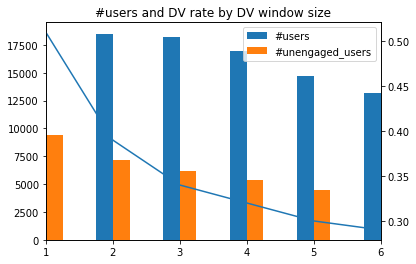

In [67]:
size_summary_df[['#users', '#unengaged_users']].plot(kind='bar')
size_summary_df['dv_rate'].plot(kind='line', secondary_y=True,
                                title='#users and DV rate by DV window size')
ax = plt.gca()
ax.set_xticklabels(size_summary_df['size'])
ax.set_xlabel('size')

### How do we choose the appropriate size of DV calculation window
0. From the above plot, it's clear that size 3 looks optimal for the following reasons:

a. The drop in population size (# users) seems high from size=3 onwards

b. The rate of drop in DV rate has also reduced from 34% to 29% from size=3 to size=6

There's another approach to validate this observation
1. P(user unengaged in 6 months/user unengaged in 3 months) = probability of a user remaining unengaged in 6 months given that he was unengaged in 3 months. If this probability is high, then it means that 3 months is a suitable size for DV window and should be sufficient for the analysis.

In [68]:
mask1 = transactions_df['created_date'] > observation_point_6m
mask2 = transactions_df['created_date'] <= observation_point_3m
tmp = transactions_df.loc[mask1&mask2, :]
tmp.reset_index(drop=True, inplace=True)
custom_dv_df_3m = pd.DataFrame(tmp.groupby(['user_id', 'vintage'])[
        'transaction_id'].nunique())
custom_dv_df_3m.reset_index(inplace=True)
custom_dv_df_3m.columns = ['user_id', 'vintage', 'num_transactions']

In [69]:
print(custom_dv_df_3m.shape)
print(custom_dv_df_3m.head())

(41151, 3)
  user_id  vintage  num_transactions
0  user_0  2018-11                 2
1  user_0  2018-12                10
2  user_0  2019-01                 7
3  user_0  2019-02                 9
4  user_1  2018-12                 8


In [70]:
custom_dv_df_3m_agg = _agg_user(custom_dv_df_3m)

In [71]:
print(custom_dv_df_3m_agg.shape)
print(custom_dv_df_3m_agg.head())

(14694, 6)
      user_id  mean_num_transactions  std_num_transactions  \
0      user_0               7.000000              3.559026   
1      user_1               4.666667              3.055050   
2     user_10              64.250000             32.673894   
3    user_100               6.500000              0.707107   
4  user_10000               6.750000              2.753785   

   perc25_num_transactions  perc75_num_transactions  \
0                     5.75                     9.25   
1                     3.00                     6.00   
2                    38.25                    88.50   
3                     6.25                     6.75   
4                     4.75                     8.50   

  outlier_bounds_num_transactions  
0                         (2, 10)  
1                          (2, 8)  
2                        (33, 99)  
3                          (6, 7)  
4                         (4, 10)  


In [72]:
feats_df_6m = _agg(transactions_df, observation_point_6m,
                   agg_type='pre_obs')
feats_df_6m_agg = _agg_user(feats_df_6m)

num_transactions


In [73]:
custom_dv_feats_3m_agg = _merge(custom_dv_df_3m_agg, feats_df_6m_agg)

In [74]:
custom_dv_feats_3m_agg.fillna(value=0, inplace=True)

In [75]:
print(custom_dv_feats_3m_agg.shape)
print(custom_dv_feats_3m_agg.head())

(14734, 11)
     user_id  mean_num_transactions_pre_obs  std_num_transactions_pre_obs  \
0     user_0                      22.000000                     12.922848   
1     user_1                      11.666667                     10.416333   
2    user_10                      54.181818                     16.527663   
3   user_100                       8.222222                      7.446103   
4  user_1000                       9.750000                      9.178780   

   perc25_num_transactions_pre_obs  perc75_num_transactions_pre_obs  \
0                             13.0                            27.50   
1                              7.0                            12.00   
2                             45.5                            61.50   
3                              3.0                             8.00   
4                              5.0                            11.75   

   lower_bound_num_transactions_pre_obs  mean_num_transactions_post_obs  \
0                      

In [76]:
custom_dv_feats_3m_agg['DV'] = map(lambda x, y: 1 if x < y else 0,
                                   custom_dv_feats_3m_agg['mean_num_transactions_post_obs'],
                                   custom_dv_feats_3m_agg['lower_bound_num_transactions_pre_obs'])

In [77]:
custom_dv_feats_3m_agg = pd.merge(
    custom_dv_feats_3m_agg, user_trans_summary_df[['user_id',
                                                   'trans_history_6m_30d_flag']],
    on='user_id', how='inner')

In [80]:
mask = custom_dv_feats_3m_agg['trans_history_6m_30d_flag']==1
print(mask.sum())
print(custom_dv_feats_3m_agg.loc[mask, 'DV'].value_counts())
print(custom_dv_feats_3m_agg.loc[mask, 'DV'].mean())

13141
0    8266
1    4875
Name: DV, dtype: int64
0.37097633361235827


In [82]:
mask = custom_dv_feats_3m_agg['trans_history_6m_30d_flag']==1
mask1 = custom_dv_feats_3m_agg['DV'] == 1
users_unengaged_3m = custom_dv_feats_3m_agg.loc[mask&mask1, 'user_id'].unique().tolist()
num_users_unengaged_3m = len(users_unengaged_3m)
mask = dv_feats_6m_agg['trans_history_6m_30d_flag']==1
mask1 = dv_feats_6m_agg['DV'] == 1
mask2 = dv_feats_6m_agg['user_id'].isin(users_unengaged_3m)
users_unengaged_6m = dv_feats_6m_agg.loc[mask&mask1&mask2, 'user_id'].unique().tolist()
num_users_unengaged_6m = len(users_unengaged_6m)
print('# users unengaged in 3 months: %d' %num_users_unengaged_3m)
print('# users who were unengaged in 3 months and remained unengaged in 6 months: %d' %num_users_unengaged_6m)
print('Ratio: ', (1.*num_users_unengaged_6m/num_users_unengaged_3m))

# users unengaged in 3 months: 4875
# users who were unengaged in 3 months and remained unengaged in 6 months: 3653
('Ratio: ', 0.7493333333333333)


#### ~75% of the users who were unengaged in 3 months between 2018-11-16 and 2019-02-16 remained unengaged in 6 months between 2018-11-16 and 2019-05-16. This is a pretty high number. So, this coupled with the previous observation that the population size decreases significantly with increase in DV window size makes size = 3 a good option

### Inference
1. Observation Point = 2019-02-16 18:22:16.959896
2. DV Measurement Period - 2019-02-16 18:22:16.959896 - 2019-05-16 18:22:16.959896
3. Target metric for user engagement (DV) - unengaged (1) if mean number of transactions in the DV period < lower bound (calculated using outlier logic) of the number of transactions in the period before observation point
4. Users in the analysis - Only users with at least 1 month of transaction history before observation point are considered in the analysis
5. Number of Users - 18227; DV Rate - 34.09%

## Question 3 - Classification

In [101]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from math import log
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics

In [84]:
mask = dv_feats_3m_agg['trans_history_3m_30d_flag'] == 1
cols = ['user_id', 'DV']
dv_df = dv_feats_3m_agg.loc[mask, cols]
dv_df.reset_index(drop=True, inplace=True)
print(dv_df.shape)
print(dv_df['DV'].mean())
print(dv_df.head())

(18227, 2)
0.3408679431612443
     user_id  DV
0     user_0   0
1     user_1   0
2    user_10   0
3   user_100   0
4  user_1000   1


In [117]:
UID = 'user_id'
OBS_POINT = observation_point_3m
DV = 'DV'
SAMPLE = 'sample'
FEAT_PREFIX = 'REV'

In [102]:
# Sampling
def sample_split(data, split=0.3, random_state=121212):
    """
    stratified sampling into 70% dev and 30% val
    """
    df = data.copy()
    features = [x for x in list(df.columns) if x!=DV]
    x_train, x_test, y_train, y_test = train_test_split(
     df[features], df[DV], test_size=split,
     random_state=random_state)
    # dev and val samples
    dev = pd.concat([x_train, y_train], axis=1)
    dev['sample'] = 'dev'
    val = pd.concat([x_test, y_test], axis=1)
    val['sample'] = 'val'
    cols = features + [DV, 'sample']
    df1 = pd.concat([dev[cols], val[cols]], axis=0)
    df1.reset_index(drop=True, inplace=True)
    return df1

In [89]:
dv_df = sample_split(dv_df)

In [94]:
print(dv_df.shape)
print(dv_df[SAMPLE].value_counts())
print(pd.crosstab(dv_df[SAMPLE], dv_df[DV]))

(18227, 3)
dev    12758
val     5469
Name: sample, dtype: int64
DV         0     1
sample            
dev     8404  4354
val     3610  1859


In [95]:
# WOE is a good strategy for encoding categorical features
# - better than one hot encoding
def get_woe(feat_series, dv_series):
    """
    returns WOE which stands for weight of evidence
    """
    table = pd.crosstab(feat_series, dv_series)
    table.reset_index(inplace=True)
    table.rename(columns={0: '#good', 1: '#bad'}, inplace=True)
    total_good = table['#good'].sum()
    total_bad = table['#bad'].sum()
    table['perc_good'] = table['#good'].apply(lambda x: x/float(total_good))
    table['perc_bad'] = table['#bad'].apply(lambda x: x/float(total_bad))
    mask = (table['perc_good'] != 0) & (table['perc_bad'] != 0)
    table.loc[mask, 'WOE'] = map(
     lambda x, y: log(x / float(y)), table.loc[mask, 'perc_good'],
     table.loc[mask, 'perc_bad'])
    table.loc[~mask, 'WOE'] = np.NaN
    table.reset_index(drop=True, inplace=True)
    return table

#### Features from devices dataset

In [165]:
feats_df = pd.merge(dv_df, devices_df, on='user_id', how='left')
print(feats_df.shape)
print(feats_df['brand'].value_counts())
print(pd.crosstab(feats_df.loc[mask, DV], feats_df.loc[mask, 'brand']))

(18227, 4)
Android    9109
Apple      9075
Unknown      43
Name: brand, dtype: int64
brand  Android  Apple  Unknown
DV                            
0           16      9        1
1            0      3        0


In [166]:
mask = feats_df[SAMPLE] == 'dev'
table = get_woe(feats_df.loc[mask, 'brand'], feats_df.loc[mask, DV])
map_dict = dict(zip(table['brand'], table['WOE']))
map_dict

{'Android': 0.06712468467713659,
 'Apple': -0.06831392297443369,
 'Unknown': 0.7286815409494923}

In [167]:
feats_df['brand'] = feats_df['brand'].map(map_dict)

#### Features from users dataset
1. Assumption - All the information available in the users dataset are assumed to be calculated as of created_date which is the date on which the user was added to the system. With this, we can safely calculate features based off of this information as this is before observation point

In [168]:
feats_df = pd.merge(feats_df, users_df, on='user_id', how='left')

In [169]:
print(feats_df.shape)
print(feats_df.dtypes)

(18227, 15)
user_id                                             object
DV                                                   int64
sample                                              object
brand                                              float64
birth_year                                           int64
country                                             object
city                                                object
created_date                                datetime64[ns]
user_settings_crypto_unlocked                        int64
plan                                                object
attributes_notifications_marketing_push            float64
attributes_notifications_marketing_email           float64
num_contacts                                         int64
num_referrals                                        int64
num_successful_referrals                             int64
dtype: object


In [170]:
drop_cols = []
feats_df['approx_age'] = feats_df['birth_year'].apply(
    lambda x: OBS_POINT.year - x)
drop_cols.append('birth_year')
feats_df['days_on_book'] = feats_df['created_date'].apply(
    lambda x: (OBS_POINT - x).days)
drop_cols.append('created_date')
feats_df.drop(drop_cols, axis=1, inplace=True)

In [283]:
# function to group values of discrete variables to account for low frequencies
from collections import Counter

def group_cats_with_lower_freq(data, cat_col, freq_thresh=20):
    """
    groups values which are of lower frequencies
    """
    mask = data[SAMPLE] == 'dev'
    cats = data.loc[mask, cat_col].value_counts().to_dict()
    good_cats = [k for k, v in cats.items() if v >= freq_thresh]
    return good_cats

In [178]:
for col in ['country', 'city', 'plan']:
    print(col)
    # grouping values based on freq
    grouped_values = group_cats_with_lower_freq(feats_df, col)
    mask = feats_df[col].isin(grouped_values)
    # imputing values with freq < 20
    feats_df.loc[~mask, col] = 'others'
    # WOE calculation
    mask = feats_df[SAMPLE] == 'dev'
    table = get_woe(feats_df.loc[mask, col], feats_df.loc[mask, DV])
    map_dict = dict(zip(table[col], table['WOE']))
    # encoding
    feats_df[col] = feats_df[col].map(map_dict)

country
city
plan


In [184]:
print(feats_df['user_settings_crypto_unlocked'].value_counts())
print(feats_df['attributes_notifications_marketing_push'].value_counts())
print(feats_df['attributes_notifications_marketing_email'].value_counts())
print(feats_df['num_contacts'].describe())
print(feats_df['num_referrals'].describe())
print(feats_df['num_successful_referrals'].describe())

0    14799
1     3428
Name: user_settings_crypto_unlocked, dtype: int64
1.0    11108
0.0      650
Name: attributes_notifications_marketing_push, dtype: int64
1.0    10524
0.0     1234
Name: attributes_notifications_marketing_email, dtype: int64
count    18227.000000
mean        18.302683
std         47.348969
min          0.000000
25%          0.000000
50%          5.000000
75%         19.000000
max       2918.000000
Name: num_contacts, dtype: float64
count    18227.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: num_referrals, dtype: float64
count    18227.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: num_successful_referrals, dtype: float64


In [185]:
# dropping num_referrals and num_successful_referrals as their standard deviation is zero (constant)
feats_df.drop(['num_referrals', 'num_successful_referrals'], axis=1,
              inplace=True)
# missing values in attributes_notifications_marketing_email and attributes_notifications_marketing_push can be handled during preprocessing

#### Features from notification dataset

In [192]:
notify_raw_df = pd.merge(feats_df[[UID, DV, SAMPLE]], notifications_df,
                         on='user_id', how='left')
# filter based on observation point
notify_raw_df['created_date'] = notify_raw_df['created_date'].apply(
    lambda x: pd.to_datetime(x))
mask = notify_raw_df['created_date'] <= OBS_POINT # only users who have notification history on or before observation date
notify_raw_df = notify_raw_df.loc[mask, :]
notify_raw_df.reset_index(drop=True, inplace=True)
print(notify_raw_df.shape)
print(notify_raw_df.user_id.nunique())
print(notify_raw_df.head())
print(notify_raw_df.isnull().sum())

(94103, 7)
17324
      user_id  DV sample                     reason channel status  \
0  user_13137   0    dev  REENGAGEMENT_ACTIVE_FUNDS    PUSH   SENT   
1  user_13137   0    dev  REENGAGEMENT_ACTIVE_FUNDS    PUSH   SENT   
2  user_13137   0    dev           METAL_GAME_START   EMAIL   SENT   
3  user_13137   0    dev  REENGAGEMENT_ACTIVE_FUNDS    PUSH   SENT   
4  user_13137   0    dev  REENGAGEMENT_ACTIVE_FUNDS    PUSH   SENT   

                created_date  
0 2018-10-25 04:01:19.933671  
1 2018-11-18 04:53:01.094671  
2 2019-02-16 03:43:53.300671  
3 2018-12-03 04:48:25.680671  
4 2018-12-20 04:50:11.929671  
user_id         0
DV              0
sample          0
reason          0
channel         0
status          0
created_date    0
dtype: int64


In [193]:
print(notify_raw_df['reason'].value_counts())
print(notify_raw_df['channel'].value_counts())
print(notify_raw_df['status'].value_counts())

REENGAGEMENT_ACTIVE_FUNDS               35762
FIFTH_PAYMENT_PROMO                     14739
NO_INITIAL_CARD_USE                     10103
NO_INITIAL_CARD_ORDER                    9762
LOST_CARD_ORDER                          4765
NO_INITIAL_FREE_PROMOPAGE_CARD_ORDER     3876
ONBOARDING_TIPS_ACTIVATED_USERS          3138
MADE_MONEY_REQUEST_NOT_SPLIT_BILL        2338
BLACK_FRIDAY                             2109
ENGAGEMENT_SPLIT_BILL_RESTAURANT         2009
METAL_RESERVE_PLAN                       1220
PREMIUM_ENGAGEMENT_INACTIVE_CARD         1124
JOINING_ANNIVERSARY                      1083
METAL_GAME_START                          765
PUMPKIN_PAYMENT_NOTIFICATION              684
PREMIUM_ENGAGEMENT_FEES_SAVED             626
Name: reason, dtype: int64
PUSH     50498
EMAIL    40737
SMS       2868
Name: channel, dtype: int64
SENT      70203
FAILED    23900
Name: status, dtype: int64


In [223]:
def calc_counts(data, cat_col, agg_col='created_date',
                group_col='user_id', obs_point=OBS_POINT):
    """
    returns count based and time based features grouped by some categorical
    column
    """
    
    df = data.copy()
    users = df[group_col].unique().tolist()
    agg_df = pd.DataFrame({group_col: users})
    if cat_col != 'overall':
        count_feat_name = cat_col + '_{}_notification_count'
        time_since_latest_feat_name = cat_col + '_{}_days_since_latest_notification'
        time_since_earliest_feat_name = cat_col + '_{}_days_since_earliest_notification'
    else:
        count_feat_name = cat_col + '_notification_count'
        time_since_latest_feat_name = cat_col + '_days_since_latest_notification'
        time_since_earliest_feat_name = cat_col + '_days_since_earliest_notification'
    
    if cat_col != 'overall':
        cat_values = df[cat_col].unique().tolist()
        for cat_value in cat_values:
            mask = df[cat_col] == cat_value
            tmp = df.loc[mask, :]
            tmp.reset_index(drop=True, inplace=True)
            count_df = pd.DataFrame(tmp.groupby(group_col)[agg_col].nunique())
            count_df.reset_index(inplace=True)
            count_df.columns = [group_col, count_feat_name.format(cat_value)]
            latest_time_df = pd.DataFrame(tmp.groupby(group_col).agg({agg_col:
                lambda x: (obs_point-max(x)).days}))
            latest_time_df.reset_index(inplace=True)
            latest_time_df.columns = [
                group_col, time_since_latest_feat_name.format(cat_value)]
            earliest_time_df = pd.DataFrame(tmp.groupby(group_col).agg({agg_col:
                lambda x: (obs_point-min(x)).days}))
            earliest_time_df.reset_index(inplace=True)
            earliest_time_df.columns = [
                group_col, time_since_earliest_feat_name.format(cat_value)]
            agg_df = pd.merge(agg_df, count_df, on=group_col, how='left')
            agg_df = pd.merge(agg_df, latest_time_df, on=group_col, how='left')
            agg_df = pd.merge(agg_df, earliest_time_df, on=group_col, how='left')
    else:
        count_df = pd.DataFrame(df.groupby(group_col)[agg_col].nunique())
        count_df.reset_index(inplace=True)
        count_df.columns = [group_col, count_feat_name]
        latest_time_df = pd.DataFrame(df.groupby(group_col).agg({agg_col:
            lambda x: (obs_point-max(x)).days}))
        latest_time_df.reset_index(inplace=True)
        latest_time_df.columns = [
            group_col, time_since_latest_feat_name]
        earliest_time_df = pd.DataFrame(df.groupby(group_col).agg({agg_col:
            lambda x: (obs_point-min(x)).days}))
        earliest_time_df.reset_index(inplace=True)
        earliest_time_df.columns = [
            group_col, time_since_earliest_feat_name]
        agg_df = pd.merge(agg_df, count_df, on=group_col, how='left')
        agg_df = pd.merge(agg_df, latest_time_df, on=group_col, how='left')
        agg_df = pd.merge(agg_df, earliest_time_df, on=group_col, how='left')
    
    return agg_df

In [220]:
notify_feats_df = notify_raw_df[['user_id', DV, SAMPLE]]
notify_feats_df.drop_duplicates(inplace=True)

In [221]:
for col in ['reason', 'channel', 'status']:
    print(col)
    agg_df = calc_counts(notify_raw_df, col)
    notify_feats_df = pd.merge(notify_feats_df, agg_df, on='user_id')

reason
channel
status


In [232]:
# overall counts and time based features
agg_df = calc_counts(notify_raw_df, 'overall')
notify_feats_df = pd.merge(notify_feats_df, agg_df, on='user_id')

In [233]:
print(notify_feats_df.shape)
print(notify_feats_df.user_id.nunique())
print(notify_feats_df.isnull().sum())

(17324, 69)
17324
user_id                                                                             0
DV                                                                                  0
sample                                                                              0
reason_REENGAGEMENT_ACTIVE_FUNDS_notification_count                              4895
reason_REENGAGEMENT_ACTIVE_FUNDS_days_since_latest_notification                  4895
reason_REENGAGEMENT_ACTIVE_FUNDS_days_since_earliest_notification                4895
reason_METAL_GAME_START_notification_count                                      16564
reason_METAL_GAME_START_days_since_latest_notification                          16564
reason_METAL_GAME_START_days_since_earliest_notification                        16564
reason_NO_INITIAL_CARD_ORDER_notification_count                                 10904
reason_NO_INITIAL_CARD_ORDER_days_since_latest_notification                     10904
reason_NO_INITIAL_CARD_ORDER_days_si

In [234]:
feats_df = pd.merge(feats_df, notify_feats_df,
                    on=['user_id', DV, SAMPLE], how='left')

In [240]:
print(feats_df.shape)
print(feats_df.columns)

(18227, 79)
Index([u'user_id', u'DV', u'sample', u'brand', u'country', u'city',
       u'user_settings_crypto_unlocked', u'plan',
       u'attributes_notifications_marketing_push',
       u'attributes_notifications_marketing_email', u'num_contacts',
       u'approx_age', u'days_on_book',
       u'reason_REENGAGEMENT_ACTIVE_FUNDS_notification_count',
       u'reason_REENGAGEMENT_ACTIVE_FUNDS_days_since_latest_notification',
       u'reason_REENGAGEMENT_ACTIVE_FUNDS_days_since_earliest_notification',
       u'reason_METAL_GAME_START_notification_count',
       u'reason_METAL_GAME_START_days_since_latest_notification',
       u'reason_METAL_GAME_START_days_since_earliest_notification',
       u'reason_NO_INITIAL_CARD_ORDER_notification_count',
       u'reason_NO_INITIAL_CARD_ORDER_days_since_latest_notification',
       u'reason_NO_INITIAL_CARD_ORDER_days_since_earliest_notification',
       u'reason_NO_INITIAL_FREE_PROMOPAGE_CARD_ORDER_notification_count',
       u'reason_NO_INITIAL_FREE

In [241]:
### Memory Free-up
del notify_raw_df
del notify_feats_df
del agg_df

#### Features from transactions dataset

In [243]:
trans_raw_df = pd.merge(feats_df[[UID, DV, SAMPLE]], transactions_df,
                         on='user_id', how='left')
# filter based on observation point
mask = trans_raw_df['created_date'] <= OBS_POINT # only users who have transaction history on or before observation date
trans_raw_df = trans_raw_df.loc[mask, :]
trans_raw_df.reset_index(drop=True, inplace=True)
print(trans_raw_df.shape)
print(trans_raw_df.user_id.nunique())
print(trans_raw_df.head())
print(trans_raw_df.isnull().sum())

(1836306, 15)
18227
      user_id  DV sample       transaction_id transactions_type  \
0  user_13137   0    dev  transaction_2110720      CARD_PAYMENT   
1  user_13137   0    dev  transaction_2112179             TOPUP   
2  user_13137   0    dev  transaction_2113164             TOPUP   
3  user_13137   0    dev  transaction_2113481               ATM   
4  user_13137   0    dev  transaction_2113667      CARD_PAYMENT   

  transactions_currency  amount_usd transactions_state ea_cardholderpresence  \
0                   EUR       14.70           DECLINED                 FALSE   
1                   EUR       42.55          COMPLETED                   NaN   
2                   EUR        0.85           REVERTED                   NaN   
3                   EUR       17.02          COMPLETED                 FALSE   
4                   EUR        6.31          COMPLETED                 FALSE   

   ea_merchant_mcc ea_merchant_city ea_merchant_country direction  \
0           4111.0         

In [321]:
trans_feats_df = trans_raw_df[[UID, DV, SAMPLE]]
trans_feats_df.drop_duplicates(inplace=True)
trans_feats_df.reset_index(drop=True, inplace=True)
print(trans_feats_df.shape)
print(trans_feats_df.head())

(18227, 3)
      user_id  DV sample
0  user_13137   0    dev
1   user_7380   1    dev
2  user_17725   1    dev
3    user_317   0    dev
4   user_8781   1    dev


In [322]:
from collections import Counter


def get_names(n_vars, agg_funcs):
    """
    Ensures that feature names are interpretable
    """

    cols = []
    for i, func in enumerate(agg_funcs):
        prefix = n_vars[i]+"_"
        if not isinstance(func, list):
            if not hasattr(func, "__call__"):
                name = prefix+func
            else:
                name = prefix+func.__name__
            cols.append(name)
        else:
            for fn in func:
                if not hasattr(fn, "__call__"):
                    name = prefix+fn
                else:
                    name = prefix+fn.__name__
                cols.append(name)
    return cols


def calc_mode(series):
    """
    most frequent values in a series
    """

    count_dct = Counter(series)
    keys = list(count_dct.keys())
    values = list(count_dct.values())
    modes = [keys[i] for i, x in enumerate(values) if x == max(values)]
    return np.mean(modes)


def calc_simple_feats(data, n_vars, group_cols=[UID]):
    """
    features based on summary statistics
    """
    
    df = data.copy()
    # sort data in the descending order of created_date for latest value
    df.sort_values([UID, "created_date"], ascending=False, inplace=True)
    df.reset_index(drop=True, inplace=True)
    agg_funcs = [["min", "max", "mean", "median", "std", "first",
                  calc_mode]]*len(n_vars)
    agg_dct = dict(zip(n_vars, agg_funcs))
    df1 = pd.DataFrame(df.groupby(group_cols).agg(agg_dct))
    df1.reset_index(inplace=True)
    cols = group_cols + get_names(n_vars, agg_funcs)
    df1.columns = cols
    return df1


def calc_count_feats(data, name, agg_col='transaction_id',
                     group_cols=[UID]):
    """
    count based features
    """
    
    df = data.copy()
    df1 = pd.DataFrame(df.groupby(group_cols)[agg_col].nunique())
    df1.reset_index(inplace=True)
    cols = group_cols + ['{}_num_transactions'.format(name)]
    df1.columns = cols
    return df1


def calc_time_feats(data, name, agg_col='created_date', group_cols=[UID],
                    obs_point=OBS_POINT):
    """
    days since latest transaction and days since earliest transaction
    """
    
    df = data.copy()
    latest_time_df = pd.DataFrame(df.groupby(group_cols).agg({agg_col:
        lambda x: (obs_point-max(x)).days}))
    latest_time_df.reset_index(inplace=True)
    latest_time_df.columns = group_cols+[
        '{}_days_since_latest_trans'.format(name)]
    earliest_time_df = pd.DataFrame(df.groupby(group_cols).agg({agg_col:
        lambda x: (obs_point-min(x)).days}))
    earliest_time_df.reset_index(inplace=True)
    earliest_time_df.columns = group_cols+[
        '{}_days_since_earliest_trans'.format(name)]
    agg_df = pd.merge(latest_time_df, earliest_time_df, on=group_cols) 
    return agg_df


def calc_acceleration_features(data, n_vars, group_cols=[UID]):
    """
    Ratio of latest value to mean, median and max values
    """

    df = data.copy()
    df.sort_values([UID, "created_date"], ascending=False, inplace=True)
    df.reset_index(drop=True, inplace=True)
    print("feature calculation begins...\n")
    agg_funcs = [["mean", "median", "max", "first"]]*len(n_vars)
    agg_dct = dict(zip(n_vars, agg_funcs))
    df1 = pd.DataFrame(df.groupby(group_cols).agg(agg_dct))
    df1.reset_index(inplace=True)
    cols = group_cols + get_names(n_vars, agg_funcs)
    df1.columns = cols
    for n_var in n_vars:
        for approach in ["mean", "median", "max"]:
            mask = (df1["{}_{}".format(n_var, approach)].notnull()) & (df1["{}_{}".format(n_var, approach)] != 0)
            df1.loc[mask, "{}_first_to_{}".format(n_var, approach)] = list(
             map(lambda x, y: x/y, df1.loc[mask, "{}_first".format(n_var)], df1.loc[mask, "{}_{}".format(n_var, approach)]))

    cols = group_cols + [x for x in list(df1.columns) if x.find("first_to_") != -1]
    return df1[cols]

In [323]:
n_vars = ['amount_usd']

print('simple feats')
agg_df = calc_simple_feats(trans_raw_df, n_vars)
trans_feats_df = pd.merge(trans_feats_df, agg_df, on=UID)

print('acceleration feats')
agg_df = calc_acceleration_features(trans_raw_df, n_vars)
trans_feats_df = pd.merge(trans_feats_df, agg_df, on=UID)

print('overall count feats')
agg_df = calc_count_feats(trans_raw_df, 'overall')
trans_feats_df = pd.merge(trans_feats_df, agg_df, on=UID)

print('overall time feats')
agg_df = calc_time_feats(trans_raw_df, 'overall')
trans_feats_df = pd.merge(trans_feats_df, agg_df, on=UID)

simple feats
acceleration feats
feature calculation begins...

overall count feats
overall time feats


In [324]:
print(trans_feats_df.shape)
print(trans_feats_df.head())

(18227, 16)
      user_id  DV sample  amount_usd_min  amount_usd_max  amount_usd_mean  \
0  user_13137   0    dev            0.00         2553.19       264.570000   
1   user_7380   1    dev            1.00         2575.81      1094.583913   
2  user_17725   1    dev            0.00          165.35        40.636389   
3    user_317   0    dev            0.00          600.00        16.186532   
4   user_8781   1    dev            0.85          102.13        18.330000   

   amount_usd_median  amount_usd_std  amount_usd_first  amount_usd_calc_mode  \
0              14.58      589.058497              9.35                 11.42   
1            1148.94      897.161353           2575.81                579.26   
2              20.36       46.220815             28.11                 99.21   
3               3.65       60.966246              2.99                  1.00   
4               8.51       25.432143             13.69                  8.51   

   amount_usd_first_to_mean  amount_usd_firs

In [307]:
# ea_merchant_mcc, ea_merchant_city and ea_merchant_country have categories with very low frequency
for col in ['ea_merchant_mcc', 'ea_merchant_city', 'ea_merchant_country']:
    print(col)
    grouped_values = group_cats_with_lower_freq(trans_raw_df, col, 10000)
    mask = trans_raw_df[col].isin(grouped_values)
    # imputing values with freq < 10000
    trans_raw_df.loc[~mask, col] = 'others'

ea_merchant_mcc
ea_merchant_city
ea_merchant_country


In [325]:
print(trans_raw_df['ea_merchant_city'].value_counts())
print(trans_raw_df['ea_merchant_mcc'].value_counts())
print(trans_raw_df['ea_merchant_country'].value_counts())

others           1686786
London             62535
Vilnius            21231
Bucuresti          20175
Dublin             15566
35314369001        15300
help.uber.com      14713
Name: ea_merchant_city, dtype: int64
others    1120281
5812.0     158392
5411.0     152473
6011.0      67489
5814.0      67431
4121.0      43661
5499.0      40206
4111.0      39355
5813.0      36141
5541.0      29913
7011.0      23965
5311.0      22260
5999.0      17419
5912.0      17320
Name: ea_merchant_mcc, dtype: int64
others    993079
GBR       315284
IRL        74666
USA        74054
FRA        67309
POL        55701
ESP        44193
NLD        38212
LTU        30193
DEU        21205
ROM        20911
LUX        19628
ITA        19165
AUS        18781
ROU        15650
CZE        14844
MLT        13431
Name: ea_merchant_country, dtype: int64


In [326]:
cat_cols = ['transactions_type', 'transactions_state', 'direction',
            'ea_merchant_mcc', 'ea_merchant_city', 'ea_merchant_country',
            'ea_cardholderpresence']
n_vars = ['amount_usd']
prefix = '{}_{}'

for cat_col in cat_cols:
    print(cat_col)
    cat_values = trans_raw_df[cat_col].unique().tolist()
    for cat_value in cat_values:
        print(cat_value)
        mask = trans_raw_df[cat_col] == cat_value
        tmp = trans_raw_df.loc[mask, :]
        tmp.reset_index(drop=True, inplace=True)
        print(tmp.shape)
        
        print('simple feats')
        simple_df = calc_simple_feats(tmp, n_vars)
        rename_cols = [x for x in list(simple_df.columns) if x!=UID]
        new_rename_cols = [prefix.format(cat_col, cat_value)+'_'+str(x) for x
                           in rename_cols]
        simple_df.rename(columns=dict(zip(rename_cols, new_rename_cols)),
                         inplace=True)
        trans_feats_df = pd.merge(trans_feats_df, simple_df, on=UID,
                                  how='left')

        print('acceleration feats')
        acc_df = calc_acceleration_features(tmp, n_vars)
        rename_cols = [x for x in list(acc_df.columns) if x!=UID]
        new_rename_cols = [prefix.format(cat_col, cat_value)+'_'+str(x) for x
                           in rename_cols]
        acc_df.rename(columns=dict(zip(rename_cols, new_rename_cols)),
                      inplace=True)
        trans_feats_df = pd.merge(trans_feats_df, acc_df, on=UID,
                                  how='left')

        print('count feats')
        count_df = calc_count_feats(tmp,
                                    prefix.format(cat_col, cat_value))
        trans_feats_df = pd.merge(trans_feats_df, count_df, on=UID,
                                  how='left')

        print('time feats')
        time_df = calc_time_feats(tmp,
                                  prefix.format(cat_col, cat_value))
        trans_feats_df = pd.merge(trans_feats_df, time_df, on=UID,
                                  how='left')

transactions_type
CARD_PAYMENT
(1000897, 15)
simple feats
acceleration feats
feature calculation begins...

count feats
time feats
TOPUP
(280812, 15)
simple feats
acceleration feats
feature calculation begins...

count feats
time feats
ATM
(67411, 15)
simple feats
acceleration feats
feature calculation begins...

count feats
time feats
TRANSFER
(305023, 15)
simple feats
acceleration feats
feature calculation begins...

count feats
time feats
CARD_REFUND
(8046, 15)
simple feats
acceleration feats
feature calculation begins...

count feats
time feats
CASHBACK
(38261, 15)
simple feats
acceleration feats
feature calculation begins...

count feats
time feats
EXCHANGE
(113534, 15)
simple feats
acceleration feats
feature calculation begins...

count feats
time feats
FEE
(19246, 15)
simple feats
acceleration feats
feature calculation begins...

count feats
time feats
TAX
(1819, 15)
simple feats
acceleration feats
feature calculation begins...

count feats
time feats
REFUND
(1257, 15)
simple fe

In [327]:
print(trans_feats_df.shape)
print(trans_feats_df.head())

(18227, 796)
      user_id  DV sample  amount_usd_min  amount_usd_max  amount_usd_mean  \
0  user_13137   0    dev            0.00         2553.19       264.570000   
1   user_7380   1    dev            1.00         2575.81      1094.583913   
2  user_17725   1    dev            0.00          165.35        40.636389   
3    user_317   0    dev            0.00          600.00        16.186532   
4   user_8781   1    dev            0.85          102.13        18.330000   

   amount_usd_median  amount_usd_std  amount_usd_first  amount_usd_calc_mode  \
0              14.58      589.058497              9.35                 11.42   
1            1148.94      897.161353           2575.81                579.26   
2              20.36       46.220815             28.11                 99.21   
3               3.65       60.966246              2.99                  1.00   
4               8.51       25.432143             13.69                  8.51   

   amount_usd_first_to_mean  amount_usd_fir

In [344]:
# checks
user = 'user_7380'
mask = trans_raw_df[UID] == user
tmp = trans_raw_df.loc[mask, :]
tmp.reset_index(drop=True, inplace=True)
tmp.sort_values('created_date', ascending=False, inplace=True)
tmp.reset_index(drop=True, inplace=True)
mask = tmp['transactions_type'] == 'TOPUP'
print(tmp.loc[mask, 'amount_usd'].std())

896.0237582787636


#### Combining all feature classes

In [465]:
USE_TRANS_FEATS = True
USE_TRANS_COUNT_FEATS = False

In [466]:
trans_feat_cols = [x for x in list(trans_feats_df.columns) if x not in
                   [UID, DV, SAMPLE]]
trans_feat_cols_w_count = [x for x in list(trans_feats_df.columns) if (x
                           not in [UID, DV, SAMPLE]) and
                           (not x.endswith('num_transactions'))]
print(len(trans_feat_cols), '\t', len(trans_feat_cols_w_count))

(793, '\t', 732)


In [467]:
if USE_TRANS_FEATS & USE_TRANS_COUNT_FEATS:
    print("All features")
    final_feats_df = pd.merge(feats_df, trans_feats_df,
                              on=[UID, DV, SAMPLE], how='left')
elif USE_TRANS_FEATS:
    print("All features except transaction count features")
    final_feats_df = pd.merge(feats_df, trans_feats_df[[UID, DV, SAMPLE]+trans_feat_cols_w_count],
                              on=[UID, DV, SAMPLE], how='left')
else:
    print("No transaction features")
    final_feats_df = feats_df.copy()

All features except transaction count features


In [468]:
# adding prefix to features
feat_cols = [x for x in list(final_feats_df.columns) if x not in
             [UID, DV, SAMPLE]]
new_feat_cols = [FEAT_PREFIX+'_'+x for x in feat_cols]
rename_dct = dict(zip(feat_cols, new_feat_cols))
final_feats_df.rename(columns=rename_dct, inplace=True)
print(final_feats_df.shape)
print(final_feats_df.columns)

(18227, 811)
Index([u'user_id', u'DV', u'sample', u'REV_brand', u'REV_country', u'REV_city',
       u'REV_user_settings_crypto_unlocked', u'REV_plan',
       u'REV_attributes_notifications_marketing_push',
       u'REV_attributes_notifications_marketing_email',
       ...
       u'REV_ea_cardholderpresence_UNKNOWN_amount_usd_mean',
       u'REV_ea_cardholderpresence_UNKNOWN_amount_usd_median',
       u'REV_ea_cardholderpresence_UNKNOWN_amount_usd_std',
       u'REV_ea_cardholderpresence_UNKNOWN_amount_usd_first',
       u'REV_ea_cardholderpresence_UNKNOWN_amount_usd_calc_mode',
       u'REV_ea_cardholderpresence_UNKNOWN_amount_usd_first_to_mean',
       u'REV_ea_cardholderpresence_UNKNOWN_amount_usd_first_to_median',
       u'REV_ea_cardholderpresence_UNKNOWN_amount_usd_first_to_max',
       u'REV_ea_cardholderpresence_UNKNOWN_days_since_latest_trans',
       u'REV_ea_cardholderpresence_UNKNOWN_days_since_earliest_trans'],
      dtype='object', length=811)


### Preprocessing of features
1. Missing value imputation - median works well
2. Outlier treatment
3. Scaling

In [469]:
def _median_imputation(feats_data):
    mask = feats_data[SAMPLE] == 'dev'
    dev = feats_data.loc[mask, :]
    dev.reset_index(drop=True, inplace=True)
    feat_cols = [x for x in list(dev.columns) if x.startswith(FEAT_PREFIX)]
    _medians = []
    _keep_cols = []
    for col in feat_cols:
        mask = dev[col].notnull()
        if mask.sum() > 0:  # not entirely missing in dev
            _keep_cols.append(col)
            _medians.append(dev.loc[mask, col].median())
    return _keep_cols, dict(zip(_keep_cols, _medians))

In [470]:
# prediction
def get_prediction(model, x_test):
    return model.predict_proba(x_test)[:, 1]

def auc(actual, pred_prob):
    return roc_auc_score(actual, pred_prob)

In [471]:
keep_cols, impute_dct = _median_imputation(final_feats_df)
print(len(keep_cols), len(impute_dct))

(796, 796)


In [444]:
final_feats_df_pre = final_feats_df[[UID, DV, SAMPLE]+keep_cols]
final_feats_df_pre.fillna(value=impute_dct, inplace=True)
print(final_feats_df_pre.shape)

(18227, 79)


In [445]:
# getting train and test data
mask = final_feats_df_pre[SAMPLE] == "dev"
x_train, y_train = final_feats_df_pre.loc[mask, keep_cols], final_feats_df_pre.loc[mask, DV]
x_test, y_test = final_feats_df_pre.loc[~mask, keep_cols], final_feats_df_pre.loc[~mask, DV]

In [446]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

((12758, 76), (12758,))
((5469, 76), (5469,))


In [463]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(max_iter=1000, C=1.5,
                         penalty='l2')
%time clf.fit(x_train, y_train)

CPU times: user 6.68 s, sys: 38.3 ms, total: 6.72 s
Wall time: 6.76 s


LogisticRegression(C=1.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [398]:
# LRl1
print("test AUC (without transaction features): %0.4f" %auc(y_test, get_prediction(clf, x_test)))
print("train AUC (without transaction features): %0.4f" %auc(y_train, get_prediction(clf, x_train)))

test AUC (without transaction features): 0.7404
train AUC (without transaction features): 0.7549


In [464]:
# LRl2
print("test AUC (without transaction features): %0.4f" %auc(y_test, get_prediction(clf, x_test)))
print("train AUC (without transaction features): %0.4f" %auc(y_train, get_prediction(clf, x_train)))

test AUC (without transaction features): 0.7401
train AUC (without transaction features): 0.7548


In [418]:
# LRl1
print("test AUC (with transaction features but without count features): %0.4f" %auc(y_test, get_prediction(clf, x_test)))
print("train AUC (with transaction features but without count features): %0.4f" %auc(y_train, get_prediction(clf, x_train)))

test AUC (with transaction features but without count features): 0.8336
train AUC (with transaction features but without count features): 0.8817


In [459]:
# XGBoost

import xgboost as xgb
import operator

MODEL_PATH = os.path.join(OUT_DIR, 'models')
if not os.path.isdir(MODEL_PATH):
    os.makedirs(MODEL_PATH)
    
    
def create_feature_map(features, fn):
    outfile = open(os.path.join(MODEL_PATH,fn), 'w')
    for i, feat in enumerate(features):
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
    outfile.close()

def runXGB(fn, train_X, train_y, test_X, test_y=None, test_X2=None,
           feature_names=None, seed_val=0, rounds=500, dep=8, eta=0.05):
    params = {}
    params["objective"] = "binary:logistic"
    params['eval_metric'] = 'auc'
    params["eta"] = eta
    params["subsample"] = 0.8
    params["min_child_weight"] = 1
    params["colsample_bytree"] = 0.7
    params["max_depth"] = dep

    params["silent"] = 1
    params["seed"] = seed_val
    # params["max_delta_step"] = 2
    # params["gamma"] = 0.5
    num_rounds = rounds

    plst = list(params.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)

    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y)
        watchlist = [(xgtrain, 'train'), (xgtest, 'test')]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist,
                          early_stopping_rounds=20, verbose_eval=20)
    else:
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plst, xgtrain, num_rounds)

    if feature_names is not None:
        create_feature_map(feature_names, fn)
        model.dump_model(os.path.join(MODEL_PATH,'raw_feats_xgb.txt'),
                         os.path.join(MODEL_PATH,fn), with_stats=True)
        importance = model.get_fscore(fmap=os.path.join(MODEL_PATH,fn))
        importance = sorted(importance.items(), key=operator.itemgetter(1),
                            reverse=True)
        imp_df = pd.DataFrame(importance, columns=['feature', 'fscore'])
        imp_df['fscore'] = imp_df['fscore'] / imp_df['fscore'].sum()
        imp_df.to_csv(os.path.join(MODEL_PATH,"raw_imp_feats_xgb.csv"),
                      index=False)

    pred_test_y = model.predict(xgtest, ntree_limit=model.best_ntree_limit)
    if test_X2:
        pred_test_y2 = model.predict(xgb.DMatrix(test_X2),
                                     ntree_limit=model.best_ntree_limit)
    else:
        pred_test_y2 = None

    loss = 0
    if test_y is not None:
        loss = metrics.roc_auc_score(test_y, pred_test_y)

    return pred_test_y, loss, pred_test_y2, model

In [472]:
# XGB algo can handle missing values. So, imputation is not needed
# train and test data on raw data
mask = final_feats_df[SAMPLE] == "dev"
x_train_raw, y_train_raw = final_feats_df.loc[mask, keep_cols], final_feats_df.loc[mask, DV]
dev_cids = final_feats_df.loc[mask, UID].tolist()
x_test_raw, y_test_raw = final_feats_df.loc[~mask, keep_cols], final_feats_df.loc[~mask, DV]
val_cids = final_feats_df.loc[~mask, UID].tolist()

In [473]:
print(x_train_raw.shape)
print(y_train_raw.shape)
print(x_test_raw.shape)
print(y_test_raw.shape)
print(y_train_raw.value_counts())
print(y_test_raw.value_counts())

(12758, 796)
(12758,)
(5469, 796)
(5469,)
0    8404
1    4354
Name: DV, dtype: int64
0    3610
1    1859
Name: DV, dtype: int64


In [477]:
# XGB model with transaction features excluding count based features
import time
start = time.time()
pred_val, loss, pred_test, model = runXGB(
                 "raw_feats_xgb.fmap", x_train_raw,
                 y_train_raw, x_test_raw, y_test_raw,
                 None, rounds=80, dep=2, feature_names=keep_cols)
print("time taken: %0.2f" %(time.time()-start))

[0]	train-auc:0.829345	test-auc:0.8197
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 20 rounds.
[20]	train-auc:0.859688	test-auc:0.849046
[40]	train-auc:0.867234	test-auc:0.854671
[60]	train-auc:0.871317	test-auc:0.857438
[79]	train-auc:0.874528	test-auc:0.85997
time taken: 12.76


In [462]:
# XGB model without transaction features
import time
start = time.time()
pred_val, loss, pred_test, model = runXGB(
                 "raw_feats_without_trans_feats_xgb.fmap", x_train_raw,
                 y_train_raw, x_test_raw, y_test_raw,
                 None, rounds=600, dep=1, feature_names=keep_cols)
print("time taken: %0.2f" %(time.time()-start))

[0]	train-auc:0.668765	test-auc:0.653106
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 20 rounds.
[20]	train-auc:0.733071	test-auc:0.717557
[40]	train-auc:0.753658	test-auc:0.735399
[60]	train-auc:0.766317	test-auc:0.746146
[80]	train-auc:0.772586	test-auc:0.753076
[100]	train-auc:0.775779	test-auc:0.755552
[120]	train-auc:0.778206	test-auc:0.758506
[140]	train-auc:0.781132	test-auc:0.761941
[160]	train-auc:0.78293	test-auc:0.763582
[180]	train-auc:0.784557	test-auc:0.764829
[200]	train-auc:0.785966	test-auc:0.766141
[220]	train-auc:0.787129	test-auc:0.767307
[240]	train-auc:0.788247	test-auc:0.768045
[260]	train-auc:0.789269	test-auc:0.769109
[280]	train-auc:0.790272	test-auc:0.770039
[300]	train-auc:0.791063	test-auc:0.770556
[320]	train-auc:0.791792	test-auc:0.771268
[340]	train-auc:0.792448	test-auc:0.771808
[360]	train-auc:0.793085	test-auc:0.77239
[380]	train-auc:0.793769	test-auc:0.773139
[400]	t

In [479]:
### Summing up the performance Numbers
perf_df = pd.DataFrame({'feats': ['without_trans_feats', 'without_trans_feats',
                                  'without_trans_feats',
                                  'with_trans_without_count_feats',
                                  'with_trans_without_count_feats'],
                        'algo': ['lrl1', 'lrl2', 'xgb', 'lrl1', 'xgb'],
                        'train_auc': [0.75, 0.75, 0.80, 0.88, 0.87],
                        'test_auc': [0.74, 0.74, 0.78, 0.83, 0.86]})
print(perf_df)

   algo                           feats  test_auc  train_auc
0  lrl1             without_trans_feats      0.74       0.75
1  lrl2             without_trans_feats      0.74       0.75
2   xgb             without_trans_feats      0.78       0.80
3  lrl1  with_trans_without_count_feats      0.83       0.88
4   xgb  with_trans_without_count_feats      0.86       0.87


### Inference
1. Model 4 which is trained on features created from devices, notifications, users and transactions dataset is picked as that has the best performance on val sample with little to no overfit (val and dev auc numbers are close)
2. Count based transaction features are ignored as they may lead to overfitting

#### Precision and Recall for the chosen model (Model 4)

In [480]:
print(pred_val.shape)
print(loss)
print(pred_test)
print(val_cids[:10])

(5469,)
0.8600108925806773
None
['user_16901', 'user_9444', 'user_16703', 'user_16325', 'user_2637', 'user_17113', 'user_2141', 'user_10349', 'user_3637', 'user_10569']


In [485]:
pred_val_df = pd.DataFrame({UID: val_cids, "pred_prob": pred_val,
                            DV: y_test})
print(pred_val_df.shape)
print(pred_val_df.head())
print(pred_val_df[DV].mean())

(5469, 3)
       DV  pred_prob     user_id
12758   0   0.173456  user_16901
12759   0   0.726200   user_9444
12760   0   0.075358  user_16703
12761   0   0.722926  user_16325
12762   0   0.089455   user_2637
0.33991588955933444


In [495]:
print(pred_val_df['pred_prob'].mean())
print(pred_val_df.groupby(DV)["pred_prob"].describe())

0.34245458
     count      mean       std       min       25%       50%       75%  \
DV                                                                       
0   3610.0  0.220754  0.197359  0.046303  0.089275  0.130728  0.281170   
1   1859.0  0.578785  0.252980  0.054143  0.378883  0.646947  0.802447   

         max  
DV            
0   0.883291  
1   0.883291  


In [494]:
from sklearn.metrics import confusion_matrix
thresholds = [x/100. for x in range(20, 41)]
for threshold in thresholds:
    print(threshold)
    preds = pred_val_df["pred_prob"].apply(lambda x: 1 if x>=threshold else 0)
    tn, fp, fn, tp = confusion_matrix(pred_val_df[DV], preds).ravel()
    if (tp+fp):
        precision = 100.*tp/(tp+fp)
    else:
        precision = None
    if (tp+fn):
        recall = 100.*tp/(tp+fn)
    else:
        recall = None
    if precision and recall:
        f_score = 2.*precision*recall/(precision+recall)
    else:
        f_score = 0
    print("True Negatives: ", tn)
    print("True Positives: ", tp)
    print("False Positives: ", fp)
    print("False Negatives: ", fn)
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("FScore: ", f_score)
    print("\n")

0.2
('True Negatives: ', 2388)
('True Positives: ', 1624)
('False Positives: ', 1222)
('False Negatives: ', 235)
('Precision: ', 57.06254392129304)
('Recall: ', 87.35879505110275)
('FScore: ', 69.03294367693942)


0.21
('True Negatives: ', 2447)
('True Positives: ', 1608)
('False Positives: ', 1163)
('False Negatives: ', 251)
('Precision: ', 58.029592204980155)
('Recall: ', 86.49811726734804)
('FScore: ', 69.46004319654428)


0.22
('True Negatives: ', 2496)
('True Positives: ', 1598)
('False Positives: ', 1114)
('False Negatives: ', 261)
('Precision: ', 58.92330383480826)
('Recall: ', 85.96019365250135)
('FScore: ', 69.91905491139795)


0.23
('True Negatives: ', 2547)
('True Positives: ', 1581)
('False Positives: ', 1063)
('False Negatives: ', 278)
('Precision: ', 59.79576399394856)
('Recall: ', 85.04572350726197)
('FScore: ', 70.21985343104596)


0.24
('True Negatives: ', 2577)
('True Positives: ', 1570)
('False Positives: ', 1033)
('False Negatives: ', 289)
('Precision: ', 60.3150211

### Best threshold (optimized for f-score) on val sample
1. Threshold = 0.31
2. Precision = 64.79%
3. Recall = 80.09%
4. F Score = 71.63%
5. AUC = 0.86

## Question 4 - Experiment to test the efficacy of a business action in reducing churn

### Experiment Settings

#### Goal
To set up an experiment to test whether a proposed business action reduces churn (disengagement of users)

#### Steps involved in conducting the experiment
1. Select the target audience - users who are likely to churn as predicted by the model
2. Partitioning the target population into control and test groups
3. Determining the sample size for control and test
4. Run the campaign and collect data
5. Measure the impact of business action

#### Details
1. Population on which the experiment is to be conducted - I use my churn model and score customers on book at a particular point in time (observation point). The score is an indication of whether a customer would churn in the next three months. Using the probability (score), we can predict a label ("churn" or "no churn") based on a suitable threshold (cut-off) that's optimized for precision (or f-score). The experiment will be conducted on the users who have a high likelihood (decided based on probability threshold) to churn because they are the target audience.

2. Partitioning the population appropriately into control group and test group - After the target audience is chosen, we have to split the population into 2 groups viz. control (champion) and test (challenger). The test group is the group on which the business action (that we want to test) would be subjected. We don't apply the business action on the control population. The partitioning into control and test has to be done randomly in such a way that the mean rate of churn remains statistically similar. The mean churn rate is nothing but the average of the predicted probabilities of the model. A properly calibrated model would have the mean actual DV being statistically similar to the mean predicted probability. Note: In the case of the val sample on which the model was validated, the actual DV rate and the mean predicted probability were both ~34%

3. Expected drop in churn because of the business action - we need to set expectations on the degree to which churn can be reduced by the business action. This is because we will need to estimate the minimum sample size needed in control and test groups to be able to make a statistically legid inference post the experiment. And, for the sample size estimation, we need to know the expected minimum difference in churn rates. Let's denote the expected minimum difference in churn probabilities as "P".

4. Statistical significance and statistical power of test - needed for estimation of sample size of control and test groups. Conceptually, significance is the probability of type I error or (1-significance) is the confidence in our estimate which is the difference in mean churn rates between the 2 groups. The power of the test is equivalent to 1-probability of type II error.

5. Experiment timelines - We need to wait for a suitable length of time before assessing the results. This is essential as users need time to respond to the treatment given to them which will reflect in their daily transactions.

#### Measurement of Impact
1. Comparison of the mean predicted churn probabilities between control group and test group after campaign - As mentioned earlier, the mean predicted probabilities of control and test before campaign are statistically same. If the campaign was effective, then we would expect the difference in the means after the campaign to be at least "P" (point 3 in requirements for conducting the experiment). We can use a "two sample  t-test" or a non-parametric test to compare the means and test the following hypothesis:

H0: p1(mean churn probability of test group after campaign) = p2(mean churn probability of control group after campaign)

Ha: p1 > p2 (one-tailed test)

Note: Observation point can be the end of campaign period. Model scores (probabilities) p1 and p2 are calculated at observation point.

2. Comparison of the means of the number of transactions done during the campaign period between control and test groups -  "two sample t-test" can be used to test the following hypothesis:

H0: mean number of transactions of test = mean number of transactions of control

Ha: mean number of transactions of test > mean number of transactions of control

3. Comparison of the means of total transaction amount of transactions done during the campaign period between control and test groups -  "two sample t-test" can be used to test the following hypothesis:

H0: mean transaction amount of test = mean transaction amount of control

Ha: mean transaction amount of test > mean transaction amount of control